In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import re
import graphlab as gl
from graphlab.toolkits.feature_engineering import TFIDF, FeatureHasher, QuadraticFeatures

gl.canvas.set_target('ipynb')

PATH_TO_JSON2 = "/mnt/sframe/docs_prod_02/"
PATH_TO_JSON = "/mnt/sframe/docs_prod_03/"
PATH_TO_TRAIN_LABELS = "input/train.csv"
PATH_TO_TEST_LABELS = "input/sampleSubmission.csv"

[WARNING] This Python session does not appear to be running in an interactive IPython Notebook. Use of the 'ipynb' target may behave unexpectedly or result in errors.


### Read processed documents

In [3]:
gl.set_runtime_config('GRAPHLAB_DEFAULT_NUM_PYLAMBDA_WORKERS', 128)
gl.set_runtime_config('GRAPHLAB_FILEIO_MAXIMUM_CACHE_CAPACITY', 100*1024*1024*1024) # 100GB
gl.set_runtime_config('GRAPHLAB_FILEIO_MAXIMUM_CACHE_CAPACITY_PER_FILE', 100*1024*1024*1024) # 100GB

[INFO] This trial license of GraphLab Create is assigned to renatbek@gmail.com and will expire on October 08, 2015. Please contact trial@dato.com for licensing options or to request a free non-commercial license for personal or academic use.

[INFO] Start server at: ipc:///tmp/graphlab_server-11466 - Server binary: /usr/local/lib/python2.7/site-packages/graphlab/unity_server - Server log: /tmp/graphlab_server_1442950938.log
[INFO] GraphLab Server Version: 1.6


In [44]:
gl.get_runtime_config()

{'GRAPHLAB_CACHE_FILE_HDFS_LOCATION': '',
 'GRAPHLAB_CACHE_FILE_LOCATIONS': '/var/tmp',
 'GRAPHLAB_DEFAULT_NUM_GRAPH_LAMBDA_WORKERS': 16,
 'GRAPHLAB_DEFAULT_NUM_PYLAMBDA_WORKERS': 128,
 'GRAPHLAB_FILEIO_ALTERNATIVE_SSL_CERT_DIR': '/etc/pki/tls/certs',
 'GRAPHLAB_FILEIO_ALTERNATIVE_SSL_CERT_FILE': '/etc/pki/tls/certs/ca-bundle.crt',
 'GRAPHLAB_FILEIO_MAXIMUM_CACHE_CAPACITY': 107374182400,
 'GRAPHLAB_FILEIO_MAXIMUM_CACHE_CAPACITY_PER_FILE': 107374182400,
 'GRAPHLAB_LIBODBC_PREFIX': '',
 'GRAPHLAB_ML_DATA_STATS_PARALLEL_ACCESS_THRESHOLD': 1048576,
 'GRAPHLAB_ML_DATA_TARGET_ROW_BYTE_MINIMUM': 262144,
 'GRAPHLAB_NEURALNET_DEFAULT_GPU_DEVICE_ID': 'auto',
 'GRAPHLAB_ODBC_BUFFER_MAX_ROWS': 2000,
 'GRAPHLAB_ODBC_BUFFER_SIZE': 3221225472,
 'GRAPHLAB_SFRAME_CSV_PARSER_READ_SIZE': 52428800,
 'GRAPHLAB_SFRAME_DEFAULT_BLOCK_SIZE': 65536,
 'GRAPHLAB_SFRAME_DEFAULT_NUM_SEGMENTS': 32,
 'GRAPHLAB_SFRAME_FILE_HANDLE_POOL_SIZE': 3072,
 'GRAPHLAB_SFRAME_GROUPBY_BUFFER_NUM_ROWS': 100765412,
 'GRAPHLAB_SFRAM

In [ ]:
# documents
sf = gl.SFrame.read_csv(PATH_TO_JSON, header=False, verbose=False)
sf = sf.unpack('X1',column_name_prefix='')
sf['id'] = sf['id'].apply(lambda x: str(x.split('_')[0] ))
sf['num_words'] = sf['text'].apply(lambda xs: transf(len(xs)))

sf2 = gl.SFrame.read_csv(PATH_TO_JSON2, header=False, verbose=False)
sf2 = sf2.unpack('X1',column_name_prefix='')
sf2['id'] = sf2['id'].apply(lambda x: str(x.split('_')[0] ))

In [ ]:
def transf(x):
    return 50.0 * np.log1p(np.log1p(x))

sf_cnt = gl.SFrame()
sf_cnt['id'] = sf2['id']

sf_cnt['a_href'] = sf2['ahref'].apply(lambda x: transf(len(x)))
sf_cnt['par'] = sf2['par'].apply(lambda x: transf(len(x)))
sf_cnt['title'] = sf2['title'].apply(lambda x: transf(len(x)))

sf_cnt['img'] = sf2['img_cnt'].apply(transf)
sf_cnt['btn'] = sf2['misc_button'].apply(transf)
sf_cnt['input'] = sf2['misc_input'].apply(transf)
sf_cnt['li'] = sf2['misc_li'].apply(transf)
sf_cnt['link'] = sf2['misc_link'].apply(transf)
sf_cnt['meta'] = sf2['misc_meta'].apply(transf)

sf_cnt['script_avg'] = sf2['script_avg'].apply(transf)
sf_cnt['script_b_avg'] = sf2['script_b_avg'].apply(transf)
sf_cnt['script_cnt'] = sf2['script_cnt'].apply(transf)
sf_cnt['script_b_cnt'] = sf2['script_b_cnt'].apply(transf)

sf_cnt['style_avg'] = sf2['style_avg'].apply(transf)
sf_cnt['style_cnt'] = sf2['style_cnt'].apply(transf)

### Read train/test labels and merge into documents

In [ ]:
# train/test labels
train_labels = gl.SFrame.read_csv(PATH_TO_TRAIN_LABELS, verbose=False)
test_labels = gl.SFrame.read_csv(PATH_TO_TEST_LABELS, verbose=False)
train_labels['id'] = train_labels['file'].apply(lambda x: str(x.split('_')[0] ))
train_labels = train_labels.remove_column('file')
test_labels['id'] = test_labels['file'].apply(lambda x: str(x.split('_')[0] ))
test_labels = test_labels.remove_column('file')

# join
train = train_labels.join(sf, on='id', how='left')
test = test_labels.join(sf, on='id', how='left')

train = train.join(sf_cnt, on='id', how='left')
test = test.join(sf_cnt, on='id', how='left')

In [4]:
features = [
            'a_href',
            'par',
            'title',
            'img',
            'btn',
            'input',
            'li',
            'link',
            'meta',
            'script_avg',
            'script_b_avg',
            'script_cnt',
            'script_b_cnt',
            'style_avg',
            'style_cnt',
            'num_words'
           ]

In [ ]:
# fill in empty
for f in features:
    train = train.fillna(f, 0.0)     
    test = test.fillna(f, 0.0)

### Generate BOW

In [ ]:
bow_trn = gl.text_analytics.count_words(train['text'])
bow_trn = bow_trn.dict_trim_by_keys(gl.text_analytics.stopwords())

bow_tst = gl.text_analytics.count_words(test['text'])
bow_tst = bow_tst.dict_trim_by_keys(gl.text_analytics.stopwords())

train['bow'] = bow_trn
test['bow'] = bow_tst

### Generate TF-IDF

In [ ]:
encoder = gl.feature_engineering.create(train, TFIDF('bow', output_column_name='tfidf', min_document_frequency=1e-5))
train = encoder.transform(train)
test = encoder.transform(test)

### Hash TF-IDF

In [ ]:
hash_encoder = gl.feature_engineering.create(train, FeatureHasher(features = ['tfidf'], num_bits=18, 
                                                                  output_column_name='tfidf_hashed_18'))
train['tfidf_hashed_18'] = hash_encoder.transform(train)['tfidf_hashed_18']
test['tfidf_hashed_18'] = hash_encoder.transform(test)['tfidf_hashed_18']

### Split training set for cross-validation

In [ ]:
train_train, train_cv = train.random_split(0.80, seed=107)

# Generate Submission Model

In [ ]:
model = gl.classifier.boosted_trees_classifier.create(train, target='sponsored',
                                                      features=features + ['tfidf_hashed_18'],
                                                      max_depth=6,
                                                      step_size=0.2,
                                                      max_iterations=300,
                                                      column_subsample=0.3,
                                                      row_subsample=1.0,
                                                      class_weights='auto',
                                                      validation_set=None)

In [ ]:
lr_model = gl.logistic_classifier.create(train, target='sponsored', 
                                      features=['tfidf_hashed'],
                                      validation_set=None,
                                      class_weights='auto',
                                      max_iterations=10,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
svm_model = gl.svm_classifier.create(train, target='sponsored', 
                                      features=['tfidf_hashed'],
                                      validation_set=None,                                           
                                      class_weights='auto',
                                      max_iterations=20)

### Output model

In [ ]:
ypred = model.predict(test, 'probability')

submission = gl.SFrame()
submission['file'] = test['id'].apply(lambda x: x + '_raw_html.txt')
submission['sponsored'] = ypred 
#submission.save('submission_version_4.csv', format='csv')

submission = submission.to_dataframe()
submission.to_csv('submission_version_6_boosted_try2.csv', index=False, float_format='%1.8f')

In [ ]:
model.save('/mnt/sframe/model_RF_100_100_040_100_bits18')

In [ ]:
test

# Experiment

### Split train into *train_train*/*train_cv*

In [ ]:
model = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=features, # + ['tfidf_hashed'],
                                      validation_set=train_cv,
                                      class_weights='auto',
                                      max_iterations=10,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
results = gl.SFrame()
results['id'] = train_cv['id']
results['actual'] = train_cv['sponsored']
results['predicted'] = model.predict(train_cv)

In [ ]:
train_cv.unpack('tfidf')

In [ ]:
FN.shape, FP.shape

In [ ]:
FN = results[results['actual'] > results['predicted']]
FP = results[results['actual'] < results['predicted']]

In [ ]:
FN[720:730]

In [ ]:
FP

In [ ]:
model.evaluate(train_cv)

In [ ]:
results = model.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
train_cv.remove_column('tfidf_hashed17')

In [ ]:
svm_model = gl.svm_classifier.create(train_train, target='sponsored', 
                                      features=features + ['tfidf_hashed'],
                                      validation_set=train_cv,                                           
                                      class_weights='auto',
                                      max_iterations=15)

In [ ]:
svm_model

In [ ]:
train_cv['margin'] = svm_model.predict(train_cv, output_type='margin')
preds = train_cv[['sponsored', 'margin']].sort('margin')
train_cv.remove_column('margin')

pd_preds = preds.to_dataframe()
pd_preds['number'] = 1.0

pd_preds_cum = pd_preds.cumsum()

total_positives = np.asarray(pd_preds_cum['sponsored'])[-1]
total = np.asarray(pd_preds_cum['number'])[-1]
total_negatives = total - total_positives

pd_preds_cum['FN'] = pd_preds_cum['sponsored']
pd_preds_cum['TN'] = pd_preds_cum['number'] - pd_preds_cum['sponsored']

pd_preds_cum['TP'] = total_positives - pd_preds_cum['FN']
pd_preds_cum['FP'] = total - total_positives - pd_preds_cum['TN']

pd_preds_cum['fpr'] = pd_preds_cum['FP'] / (pd_preds_cum['FP'] + pd_preds_cum['TN'])
pd_preds_cum['tpr'] = pd_preds_cum['TP'] / (pd_preds_cum['TP'] + pd_preds_cum['FN'])



In [ ]:
a = pd_preds_cum

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
train_cv['margin'] = svm_model.predict(train_cv, output_type='margin')
preds = train_cv[['sponsored', 'margin']]
preds['margin'].show()

In [ ]:
(preds[preds['margin'] < 55]['sponsored']).sum()

In [ ]:
ts = np.arange(-22, 50, 0.1)
[for t in ts]

In [ ]:
svm_model.evaluate(train_cv)

In [ ]:
results = svm_model.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
results

# Save Datasets?

In [ ]:
train_train.save('dataset_train_train')
train_cv.save('dataset_train_cv')
test.save('dataset_test')

# Junk

In [ ]:
hash_encoder = gl.feature_engineering.create(train_train, FeatureHasher(features = ['tfidf'], num_bits=17, 
                                                                  output_column_name='tfidf_hashed_17'))
train_train['tfidf_hashed_17'] = hash_encoder.transform(train_train)['tfidf_hashed_17']
train_cv['tfidf_hashed_17'] = hash_encoder.transform(train_cv)['tfidf_hashed_17']

In [ ]:
train_train.head()

In [ ]:
model_15 = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_15'],
                                      validation_set=train_cv,
                                      class_weights='auto',
                                      max_iterations=40,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
model_15

In [ ]:
model_15.evaluate(train_cv)

In [ ]:
results = model_15.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
model_16 = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_16'],
                                      validation_set=train_cv,
                                      class_weights='auto',
                                      max_iterations=20,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
model_16.evaluate(train_cv)

In [ ]:
results = model_16.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
model_17 = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_17'],
                                      validation_set=train_cv,
                                      class_weights=None, #'auto',
                                      max_iterations=8,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
model_17 = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_17'],
                                      validation_set=train_cv,
                                      class_weights=None, #'auto',
                                      max_iterations=7,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
model_17.evaluate(train_cv)

In [ ]:
results = model_17.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
gl.svm_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_15'],
                                      validation_set=train_cv,                                           
                                      class_weights='auto',
                                      max_iterations=40)

In [ ]:
gl.svm_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_16'],
                                      validation_set=train_cv,                                           
                                      class_weights='auto',
                                      max_iterations=40)

In [ ]:
gl.svm_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_17'],
                                      validation_set=train_cv,                                           
                                      class_weights='auto',
                                      max_iterations=40)

In [ ]:
train.head()

# Continue with data

In [5]:
train = gl.load_sframe('/mnt/sframe/counts_and_tfidf_hashed_18_train')
test = gl.load_sframe('/mnt/sframe/counts_and_tfidf_hashed_18_test')

train_train = gl.load_sframe('/mnt/sframe/num_words_counts_and_tfidf_hashed_18_split_train_train')
train_cv = gl.load_sframe('/mnt/sframe/num_words_counts_and_tfidf_hashed_18_split_train_cv')

TRAIN, CV = train_cv.random_split(0.50, seed=113)

In [ ]:
#train.save('/mnt/sframe/num_words_counts_and_tfidf_hashed_18_train')
#test.save('/mnt/sframe/num_words_counts_and_tfidf_hashed_18_test')

#train_train.save('/mnt/sframe/num_words_counts_and_tfidf_hashed_18_split_train_train')
#train_cv.save('/mnt/sframe/num_words_counts_and_tfidf_hashed_18_split_train_cv')
#train_train = gl.load_sframe('/mnt/sframe/tfidf_hashed_16_split_train_train')
#train_cv = gl.load_sframe('/mnt/sframe/tfidf_hashed_16_split_train_cv')

In [6]:
TRAIN.head()

sponsored,id,text,num_words,a_href,par,title
0,921145,canad dzeko torr teamwith miami base produc ...,115.371888151,92.1321813306,26.329451707,80.7247719851
0,921362,actor edward furlong beenarrest angel intern ...,105.746030575,85.0309500036,65.5253093102,83.5500516371
0,921468,never tire watch thilastgif.com awegif ...,99.9966524145,76.9889728976,0.0,76.9889728976
0,921558,hallo willkommenvergleichsport finden ...,116.536954207,86.0947381235,64.5862336364,81.883138126
0,92163,view cooki polici cookicooki polici use thi ...,110.011835741,76.9889728976,69.8681740587,80.3616145576
0,921926,never post without yourpermiss tzatziki tradit ...,104.933991554,83.2952546489,65.5253093102,76.9889728976
0,922092,when visit phoenix monthspent afternoon life ...,111.405091324,81.883138126,79.5842937175,81.7273451851
0,922131,know where go have goodchanc get there thi ...,112.401444139,84.2685245282,74.0938318049,87.1068371903
0,922167,indi publish slowli comerealiz import amaz book ...,121.072800505,91.605260095,87.4159048597,72.4411119183
0,922274,optim your larg gif yourimag there internet guy ...,96.0800127268,83.1647240719,37.0638155688,83.4236762641


## Try classifiers

In [ ]:
model = gl.classifier.random_forest_classifier.create(train_train, target='sponsored',
                                                      features=features + ['tfidf_hashed_18'],
                                                      num_trees=10,
                                                      max_depth=100,
                                                      column_subsample=0.45,
                                                      row_subsample=1.0,
                                                      class_weights='auto',
                                                      validation_set=train_cv)

In [ ]:
results = model.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
model_boosted = gl.classifier.boosted_trees_classifier.create(train_train, target='sponsored',
                                                      features=features + ['tfidf_hashed_18'],
                                                      max_depth=6,
                                                      step_size=0.2,
                                                      max_iterations=300,
                                                      column_subsample=0.3,
                                                      row_subsample=1.0,
                                                      class_weights='auto',
                                                      validation_set=train_cv)

In [ ]:
results = model_boosted.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
gl.boosted_trees_classifier.get_default_options()

In [ ]:
TRAIN, CV = train_cv.random_split(0.50, seed=113)

In [ ]:
CV.shape

In [ ]:
model_boosted = gl.classifier.boosted_trees_classifier.create(TRAIN, target='sponsored',
                                                      features=features + ['tfidf_hashed_18'],
                                                      max_depth=6,
                                                      step_size=0.2,
                                                      max_iterations=500,
                                                      column_subsample=0.3,
                                                      row_subsample=1.0,
                                                      class_weights='auto',
                                                      validation_set=CV)

In [ ]:
results = model_boosted.evaluate(CV, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
model_boosted = gl.classifier.boosted_trees_classifier.create(train_train, target='sponsored',
                                                      features=features + ['tfidf_hashed_18'],
                                                      max_depth=6,
                                                      step_size=0.2,
                                                      max_iterations=400,
                                                      column_subsample=0.4,
                                                      row_subsample=1.0,
                                                      class_weights='auto',
                                                      validation_set=train_cv)

AUC = 0.928255


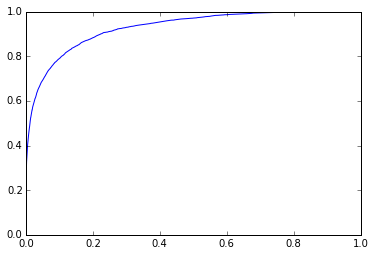

In [59]:
results = model_boosted.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
def custom_evaluator(model, train, test):
    results = model.evaluate(test, metric='roc_curve')
    a = results['roc_curve']

    fpr = list(a['fpr'])
    tpr = list(a['tpr'])
    fpr[0] = 1.0
    tpr[0] = 1.0
    fpr = np.array(fpr)
    tpr = np.array(tpr)

    AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
    return {'AUC': AUC}

In [43]:
job0 = job

In [50]:
params = dict([
        ('target', 'sponsored'),
        ('features', [features + ['tfidf_hashed_18']]),
        ('max_depth', [6]),
        ('step_size', [0.2]),
        ('max_iterations', [100, 150, 200]),
        ('column_subsample', [0.4]),
        ('validation_set', [None])
    ])

job = gl.grid_search.create((TRAIN, CV), 
                              gl.boosted_trees_classifier.create, 
                              params, 
                              evaluator=custom_evaluator)
job.get_results()

[INFO] Validating job.
[INFO] Validation complete. Job: 'Model-Parameter-Search-Sep-22-2015-21-11-1900000' ready for execution
[INFO] Job: 'Model-Parameter-Search-Sep-22-2015-21-11-1900000' scheduled.
[INFO] Validating job.
[INFO] A job with name 'Model-Parameter-Search-Sep-22-2015-21-11-1900000' already exists. Renaming the job to 'Model-Parameter-Search-Sep-22-2015-21-11-1900000-c56f4'.
[INFO] Validation complete. Job: 'Model-Parameter-Search-Sep-22-2015-21-11-1900000-c56f4' ready for execution
[INFO] Job: 'Model-Parameter-Search-Sep-22-2015-21-11-1900000-c56f4' scheduled.


Columns:
	model_id	int
	column_subsample	float
	features	list
	max_depth	int
	max_iterations	int
	step_size	float
	target	str
	validation_set	float
	AUC	float

Rows: 3

Data:
+----------+------------------+-------------------------------+-----------+----------------+
| model_id | column_subsample |            features           | max_depth | max_iterations |
+----------+------------------+-------------------------------+-----------+----------------+
|    1     |       0.4        | [a_href, par, title, img, ... |     6     |      150       |
|    0     |       0.4        | [a_href, par, title, img, ... |     6     |      100       |
|    2     |       0.4        | [a_href, par, title, img, ... |     6     |      200       |
+----------+------------------+-------------------------------+-----------+----------------+
+-----------+-----------+----------------+----------------+
| step_size |   target  | validation_set |      AUC       |
+-----------+-----------+----------------+----------------+
|    0.2    | sponsored |      None      | 0.885225034711 |
|    0.2    | sponsored |      None      | 0.880588518586 |
|    0.2    | sponsored |      None      | 0.887195333389 |
+-----------+-----------+----------------+----------------+
[3 rows x 9 columns]

In [27]:
models = job.get_models()

In [46]:
results = job.get_results()

In [47]:
results = results.to_dataframe()

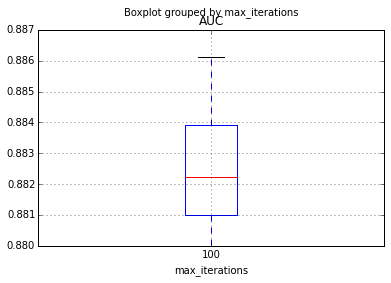

In [51]:
results.boxplot('AUC', by='max_iterations')

In [35]:
results.sort('AUC', ascending=False)

model_id,column_subsample,features,max_depth,max_iterations,step_size,target,validation_set
10,0.3,"[a_href, par, title, img,btn, input, li, link, ...",7,100,0.2,sponsored,None
19,0.4,"[a_href, par, title, img,btn, input, li, link, ...",8,100,0.2,sponsored,None
18,0.4,"[a_href, par, title, img,btn, input, li, link, ...",7,100,0.2,sponsored,None
9,0.3,"[a_href, par, title, img,btn, input, li, link, ...",6,100,0.2,sponsored,None
3,0.2,"[a_href, par, title, img,btn, input, li, link, ...",8,100,0.2,sponsored,None
2,0.2,"[a_href, par, title, img,btn, input, li, link, ...",7,100,0.2,sponsored,None
11,0.3,"[a_href, par, title, img,btn, input, li, link, ...",8,100,0.2,sponsored,None
1,0.2,"[a_href, par, title, img,btn, input, li, link, ...",6,100,0.2,sponsored,None
17,0.4,"[a_href, par, title, img,btn, input, li, link, ...",6,100,0.2,sponsored,None
21,0.4,"[a_href, par, title, img,btn, input, li, link, ...",6,100,0.3,sponsored,None


In [30]:
len(models)

24

In [52]:
job.get_metrics()

Columns:
	task_name	str
	status	str
	start_time	str
	run_time	float
	exception	float
	exception_message	float
	exception_traceback	float
	job_name	str

Rows: 4

Data:
+-----------------------+-----------+---------------------+----------------+
|       task_name       |   status  |      start_time     |    run_time    |
+-----------------------+-----------+---------------------+----------------+
| _train_test_model-0-0 | Completed | 2015-09-22 21:13:06 |  74.730946064  |
| _train_test_model-0-1 | Completed | 2015-09-22 21:14:20 | 109.418506861  |
| _train_test_model-0-2 | Completed | 2015-09-22 21:16:10 | 142.188148975  |
|   _combine_mps_tasks  | Completed | 2015-09-22 21:18:32 | 0.375344991684 |
+-----------------------+-----------+---------------------+----------------+
+-----------+-------------------+---------------------+
| exception | exception_message | exception_traceback |
+-----------+-------------------+---------------------+
|    None   |        None       |         None        |
|    None   |        None       |         None        |
|    None   |        None       |         None        |
|    None   |        None       |         None        |
+-----------+-------------------+---------------------+
+-------------------------------+
|            job_name           |
+-------------------------------+
| Model-Parameter-Search-Sep... |
| Model-Parameter-Search-Sep... |
| Model-Parameter-Search-Sep... |
| Model-Parameter-Search-Sep... |
+-------------------------------+
[4 rows x 8 columns]

In [ ]:
aa = scipy.stats.distributions.expon(.1)

In [ ]:
aa.rvs(1)